In [1]:
import os
import time
import torch
import math
import torchvision
from torchvision import transforms as transforms
from torch import nn
from torch.nn import functional as F
from math import cos,pi

import matplotlib.pyplot as plt
import numpy as np
import random

torch.cuda.empty_cache()

In [2]:
torch.cuda.is_available()

True

In [3]:
torch.manual_seed(17)
torch.cuda.manual_seed_all(17)

aug_train = transforms.Compose([
    transforms.RandomCrop(32,padding=4,padding_mode='reflect'),
    transforms.RandomHorizontalFlip(), # 水平翻转
    transforms.ToTensor(),
    transforms.Normalize((0.4244, 0.4146, 0.3836), (0.2539, 0.2491, 0.2420)) # normalization
    ])

aug_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4244, 0.4146, 0.3836), (0.2539, 0.2491, 0.2420)) # normalization
    ])

trainingdata = torchvision.datasets.CIFAR10('./CIFAR10',train=True,download=True,transform=aug_train)
# testdata = torchvision.datasets.CIFAR10('./CIFAR10',train=False,download=True,transform=transforms.ToTensor())
# print(len(trainingdata),len(testdata))

Files already downloaded and verified


In [4]:
def load_data(is_train,aug,batch_size):
    dataset = torchvision.datasets.CIFAR10('./CIFAR10',train=is_train,download=True,transform=aug)
    dataloader = torch.utils.data.DataLoader(dataset,batch_size=batch_size,shuffle=is_train)
    return dataloader

batch_size = 1024 # param
trainDataLoader = load_data(is_train=True,aug=aug_train,batch_size=batch_size)
testDataLoader = load_data(is_train=False,aug=aug_test,batch_size=batch_size)

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 32, 32]) 6


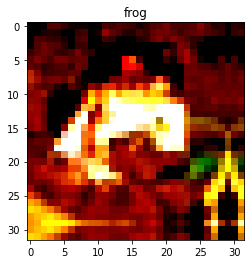

In [5]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

image,label = trainingdata[0]
print(image.shape, label)

%matplotlib inline
plt.imshow(image.numpy().transpose(1,2,0))
plt.title(str(classes[label]))
plt.show()

In [6]:
class BasicBlock(nn.Module):

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out



class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
#         self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(1024, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
#         print(x.shape)
        out = F.relu(self.bn1(self.conv1(x)))
#         print(out.shape)
        out = self.layer1(out)
#         print(out.shape)
        out = self.layer2(out)
#         print(out.shape)
        out = self.layer3(out)
#         print(out.shape)
#         out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
#         print(out.shape)
        out = out.view(out.size(0), -1)
#         print(out.shape)
        out = self.linear(out)
        return out
    
    def init_weights(self):
        for m in self.modules():
            if isinstance(m,nn.Conv2d):
                nn.init.kaiming_normal_(m.weight,mode='fan_out',nonlinearity='relu') # weight initialization
                if m.bias is not None:
                    nn.init.constant_(m.bias,0)
            elif isinstance(m,nn.BatchNorm2d):
                nn.init.constant_(m.weight,1)
                nn.init.constant_(m.bias,0)
            elif isinstance(m,nn.Linear):
                nn.init.normal_(m.weight,std=1e-3)
                if m.bias is not None:
                    nn.init.constant_(m.bias,0)

def project1_model():
#     return ResNet(BasicBlock, [2, 2, 2, 2])
    return ResNet(BasicBlock, [3, 3, 3])

# model1 = nn.Sequential(project1_model(), nn.AdaptiveAvgPool2d((1,1)), nn.Flatten(), nn.Linear(512, 10)).cuda()
model1 = project1_model().cuda()
model1.init_weights()

In [7]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    # torch.numel() returns number of elements in a tensor

print(count_parameters(model1))

4335434


In [8]:
# X = torch.rand(size=(1, 3, 32, 32)).cuda()
# for layer in model1:
#   X = layer(X)
#   print(layer.__class__.__name__,'output shape:\t', X.shape)

In [9]:
def adjust_learning_rate(optimizer, current_epoch,max_epoch,lr_min=0,lr_max=0.1,warmup=True):
    warmup_epoch = 10 if warmup else 0
    if current_epoch < warmup_epoch:
        lr = lr_max * current_epoch / warmup_epoch
    else:
        lr = lr_min + (lr_max-lr_min)*(1 + cos(pi * (current_epoch - warmup_epoch) / (max_epoch - warmup_epoch))) / 2
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [10]:
num_epochs = 500 # param
epoch_start = 0
path = 'resnet_aug_3block_sgd_warmup_consine-batch1024-lr01.pt'

train_loss_history = []
test_loss_history = []
train_accuracy_history = []
test_accuracy_history = []

Loss = torch.nn.CrossEntropyLoss()

lr = 0.1
lr_min=0.001
momentum = 0.9
nesterov = True
optimizer = torch.optim.SGD(model1.parameters(),lr=lr,momentum=momentum,nesterov=nesterov)



if os.path.exists(path):
    checkpoint = torch.load(path)
    print('Read model from checkpoint')
    model1.cuda().load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch_start = checkpoint['epoch']
    Loss = checkpoint['Loss']
    train_loss_history = checkpoint['train_loss_history']
    test_loss_history = checkpoint['test_loss_history']
    train_accuracy_history = checkpoint['train_accuracy_history']
    test_accuracy_history = checkpoint['test_accuracy_history']
    print('Restart from epoch',epoch_start)
    

for epoch in range(epoch_start+1, num_epochs+1):
    timestart = time.time()

    train_loss = 0.0
    test_loss = 0.0
    train_accuracy = 0.0
    test_accuracy = 0.0

    for i, data in enumerate(trainDataLoader):
        images, labels = data
        images = images.cuda()
        labels = labels.cuda()
        optimizer.zero_grad()
        predicted_output = model1.cuda()(images)
        fit = Loss(predicted_output,labels)
        fit.backward()
        adjust_learning_rate(optimizer=optimizer,current_epoch=epoch,max_epoch=num_epochs,lr_min=lr_min,lr_max=lr,warmup=True)
        optimizer.step()
        train_loss += fit.item()
        train_accuracy += (torch.eq(torch.max(predicted_output,1)[1],labels).sum()/len(labels)*100).data.cpu().numpy()

    for i, data in enumerate(testDataLoader):
        with torch.no_grad():
            images, labels = data
            images = images.cuda()
            labels = labels.cuda()
            predicted_output = model1.cuda()(images)
            fit = Loss(predicted_output,labels)
            test_loss += fit.item()
            test_accuracy += (torch.eq(torch.max(predicted_output,1)[1],labels).sum()/len(labels)*100).data.cpu().numpy()


    train_loss = train_loss/len(trainDataLoader)
    test_loss = test_loss/len(testDataLoader)
    train_accu = train_accuracy/len(trainDataLoader)
    test_accu = test_accuracy/len(testDataLoader)
    train_loss_history.append(train_loss)
    test_loss_history.append(test_loss)
    train_accuracy_history.append(train_accu)
    test_accuracy_history.append(test_accu)
    print('Epoch %s, Train loss %s, Test loss %s, Train accuracy %s, Test accuracy %s, Cost %s s'%(epoch,
                                                                                                   train_loss,test_loss,
                                                                                                   train_accu,test_accu,
                                                                                                   time.time()-timestart))

    if epoch % 5 == 0 and epoch != 0:
        torch.save({'epoch':epoch,
          'model_state_dict':model1.cuda().state_dict(),
          'optimizer_state_dict':optimizer.state_dict(),
          'Loss':Loss,
          'train_loss_history':train_loss_history,
          'test_loss_history':test_loss_history,
          'train_accuracy_history':train_accuracy_history,
          'test_accuracy_history':test_accuracy_history},path)
        print('Model saved in epoch %s'%(epoch))

Epoch 1, Train loss 1.8992814044563138, Test loss 1.5431559085845947, Train accuracy 28.87831061226981, Test accuracy 42.24250602722168, Cost 77.62637567520142 s
Epoch 2, Train loss 2.0369765612543844, Test loss 1.3555659294128417, Train accuracy 37.82711270390725, Test accuracy 49.73034934997558, Cost 80.0393738746643 s
Epoch 3, Train loss 1.3691449846540178, Test loss 1.12221839427948, Train accuracy 49.86000216737085, Test accuracy 59.42283172607422, Cost 78.57586646080017 s
Epoch 4, Train loss 1.188167230207093, Test loss 1.0314427256584167, Train accuracy 57.0684398728974, Test accuracy 63.21129608154297, Cost 79.98637819290161 s
Epoch 5, Train loss 1.0292773915796865, Test loss 1.0081550240516663, Train accuracy 63.090374771429566, Test accuracy 63.80181732177734, Cost 79.86976957321167 s
Model saved in epoch 5
Epoch 6, Train loss 0.9032720290884679, Test loss 0.8018073439598083, Train accuracy 67.9769852307378, Test accuracy 71.86563262939453, Cost 78.51507663726807 s
Epoch 7, T

Epoch 50, Train loss 0.045388620726916254, Test loss 0.41146539747714994, Train accuracy 98.37590556242029, Test accuracy 90.86874160766601, Cost 103.23641657829285 s
Model saved in epoch 50
Epoch 51, Train loss 0.04926851319567281, Test loss 0.38074866831302645, Train accuracy 98.3112276038345, Test accuracy 91.47201843261719, Cost 108.36675930023193 s
Epoch 52, Train loss 0.045036978487457545, Test loss 0.37727331519126894, Train accuracy 98.42888890480509, Test accuracy 91.02638702392578, Cost 110.79976034164429 s
Epoch 53, Train loss 0.04568674305111778, Test loss 0.3823519229888916, Train accuracy 98.41177928691008, Test accuracy 91.14815826416016, Cost 107.59305953979492 s
Epoch 54, Train loss 0.04462431051901409, Test loss 0.3873145252466202, Train accuracy 98.39252627625757, Test accuracy 91.10610580444336, Cost 103.14038014411926 s
Epoch 55, Train loss 0.03643903341524455, Test loss 0.4051799148321152, Train accuracy 98.76261979706433, Test accuracy 91.15872116088867, Cost 104

Epoch 99, Train loss 0.010016520127502024, Test loss 0.454212087392807, Train accuracy 99.67115752551021, Test accuracy 91.89851684570313, Cost 104.14457845687866 s
Epoch 100, Train loss 0.007648642901901384, Test loss 0.4367099434137344, Train accuracy 99.73925734539421, Test accuracy 92.1508285522461, Cost 107.46465754508972 s
Model saved in epoch 100
Epoch 101, Train loss 0.009444052529312214, Test loss 0.45536032915115354, Train accuracy 99.67472995057398, Test accuracy 92.17115783691406, Cost 100.33544778823853 s
Epoch 102, Train loss 0.008182208177310472, Test loss 0.4511519968509674, Train accuracy 99.71018997503786, Test accuracy 91.83175201416016, Cost 104.08088397979736 s
Epoch 103, Train loss 0.009240281207448974, Test loss 0.4426084101200104, Train accuracy 99.67232326585419, Test accuracy 92.2905372619629, Cost 111.17295622825623 s
Epoch 104, Train loss 0.010526792497887296, Test loss 0.4688493490219116, Train accuracy 99.64998673419564, Test accuracy 91.79408493041993, Co

Epoch 147, Train loss 0.00304572374384128, Test loss 0.484002012014389, Train accuracy 99.89636479591837, Test accuracy 92.09143829345703, Cost 101.60483503341675 s
Epoch 148, Train loss 0.0034578759365772108, Test loss 0.4781923025846481, Train accuracy 99.8844068877551, Test accuracy 92.27260055541993, Cost 109.31423330307007 s
Epoch 149, Train loss 0.0032810128723955428, Test loss 0.4905978798866272, Train accuracy 99.89113788215481, Test accuracy 92.20802764892578, Cost 100.85817408561707 s
Epoch 150, Train loss 0.003096188497563292, Test loss 0.4845829397439957, Train accuracy 99.89395826690051, Test accuracy 92.22377243041993, Cost 106.3694543838501 s
Model saved in epoch 150
Epoch 151, Train loss 0.0032078854559103444, Test loss 0.4788180857896805, Train accuracy 99.885986328125, Test accuracy 92.12990264892578, Cost 101.24733185768127 s
Epoch 152, Train loss 0.0026240109582431614, Test loss 0.4834364682435989, Train accuracy 99.91430165816327, Test accuracy 92.16657333374023, C

Epoch 195, Train loss 0.00045541178985090204, Test loss 0.501029959321022, Train accuracy 99.99003507653062, Test accuracy 92.55281372070313, Cost 100.55745720863342 s
Model saved in epoch 195
Epoch 196, Train loss 0.0004922949405486829, Test loss 0.5033663302659989, Train accuracy 99.98804209183673, Test accuracy 92.54304809570313, Cost 106.28876399993896 s
Epoch 197, Train loss 0.00038366780783541556, Test loss 0.49698285162448885, Train accuracy 99.99800701530613, Test accuracy 92.81947555541993, Cost 107.35407495498657 s
Epoch 198, Train loss 0.0003292673345826262, Test loss 0.4959906071424484, Train accuracy 99.99202806122449, Test accuracy 92.72480850219726, Cost 105.37679171562195 s
Epoch 199, Train loss 0.000513891775454442, Test loss 0.4966893374919891, Train accuracy 99.97965660873724, Test accuracy 92.59187622070313, Cost 105.70342087745667 s
Epoch 200, Train loss 0.00043039250336658706, Test loss 0.49567862749099734, Train accuracy 99.99202806122449, Test accuracy 92.600845

Epoch 243, Train loss 0.00011972286418832872, Test loss 0.4934044748544693, Train accuracy 99.99402104591837, Test accuracy 92.85475158691406, Cost 106.19389462471008 s
Epoch 244, Train loss 7.428260525965906e-05, Test loss 0.49022074937820437, Train accuracy 100.0, Test accuracy 92.98768310546875, Cost 105.82855200767517 s
Epoch 245, Train loss 6.58465575855059e-05, Test loss 0.4914038836956024, Train accuracy 100.0, Test accuracy 92.95539703369141, Cost 105.82180333137512 s
Model saved in epoch 245
Epoch 246, Train loss 5.4012172842369774e-05, Test loss 0.49184608459472656, Train accuracy 100.0, Test accuracy 92.99445953369141, Cost 101.37619352340698 s
Epoch 247, Train loss 7.432783647290103e-05, Test loss 0.492765873670578, Train accuracy 100.0, Test accuracy 92.99445953369141, Cost 101.48525404930115 s
Epoch 248, Train loss 7.547928805938774e-05, Test loss 0.4890965670347214, Train accuracy 100.0, Test accuracy 92.94941787719726, Cost 108.45889854431152 s
Epoch 249, Train loss 8.3

Epoch 294, Train loss 7.699664937328115e-05, Test loss 0.5002990007400513, Train accuracy 99.99800701530613, Test accuracy 92.9809066772461, Cost 111.32532835006714 s
Epoch 295, Train loss 6.141531096601488e-05, Test loss 0.4994719088077545, Train accuracy 100.0, Test accuracy 93.0102035522461, Cost 104.91889262199402 s
Model saved in epoch 295
Epoch 296, Train loss 4.88629979817957e-05, Test loss 0.49872546195983886, Train accuracy 100.0, Test accuracy 92.96815185546875, Cost 107.60577750205994 s
Epoch 297, Train loss 7.727872182339506e-05, Test loss 0.5010520786046981, Train accuracy 99.99800701530613, Test accuracy 92.9125473022461, Cost 101.36668968200684 s
Epoch 298, Train loss 8.153640117932216e-05, Test loss 0.5035754412412643, Train accuracy 99.99800701530613, Test accuracy 92.87727203369141, Cost 101.93004560470581 s
Epoch 299, Train loss 3.664685144550666e-05, Test loss 0.5028059720993042, Train accuracy 100.0, Test accuracy 92.89680328369141, Cost 100.7748110294342 s
Epoch 3

Epoch 345, Train loss 7.191748761902183e-05, Test loss 0.5029061049222946, Train accuracy 99.99800701530613, Test accuracy 92.96735458374023, Cost 101.08329606056213 s
Model saved in epoch 345
Epoch 346, Train loss 2.654464297123997e-05, Test loss 0.5030917793512344, Train accuracy 100.0, Test accuracy 92.94782333374023, Cost 108.92372345924377 s
Epoch 347, Train loss 4.037640554793607e-05, Test loss 0.5027924567461014, Train accuracy 100.0, Test accuracy 92.95081329345703, Cost 103.50556421279907 s
Epoch 348, Train loss 3.2892628320153064e-05, Test loss 0.5035403043031692, Train accuracy 100.0, Test accuracy 92.96057891845703, Cost 106.43394470214844 s
Epoch 349, Train loss 3.67980583827635e-05, Test loss 0.5030054986476898, Train accuracy 100.0, Test accuracy 92.99964141845703, Cost 99.59403014183044 s
Epoch 350, Train loss 3.466072526788018e-05, Test loss 0.5028541356325149, Train accuracy 100.0, Test accuracy 92.97034454345703, Cost 109.45314693450928 s
Model saved in epoch 350
Epo

Epoch 396, Train loss 2.133280702542017e-05, Test loss 0.503093421459198, Train accuracy 100.0, Test accuracy 92.98688583374023, Cost 100.99104738235474 s
Epoch 397, Train loss 2.3754166472734103e-05, Test loss 0.5030656307935715, Train accuracy 100.0, Test accuracy 92.98688583374023, Cost 101.60208129882812 s
Epoch 398, Train loss 2.4912200647772158e-05, Test loss 0.5030959963798523, Train accuracy 100.0, Test accuracy 92.98688583374023, Cost 100.21245694160461 s
Epoch 399, Train loss 2.3055575527497257e-05, Test loss 0.5033205032348633, Train accuracy 100.0, Test accuracy 93.01618270874023, Cost 100.57340741157532 s
Epoch 400, Train loss 2.3522785229534765e-05, Test loss 0.5032443165779114, Train accuracy 100.0, Test accuracy 92.9936622619629, Cost 100.79970240592957 s
Model saved in epoch 400
Epoch 401, Train loss 3.66294591690441e-05, Test loss 0.5036322981119156, Train accuracy 100.0, Test accuracy 92.9936622619629, Cost 100.6854076385498 s
Epoch 402, Train loss 2.586080005798698e

Epoch 448, Train loss 2.466141825848632e-05, Test loss 0.5036551058292389, Train accuracy 100.0, Test accuracy 92.93805770874023, Cost 107.09529304504395 s
Epoch 449, Train loss 2.1832930505464605e-05, Test loss 0.5036327987909317, Train accuracy 100.0, Test accuracy 92.92829208374023, Cost 103.58489084243774 s
Epoch 450, Train loss 2.5108451887829186e-05, Test loss 0.5036205083131791, Train accuracy 100.0, Test accuracy 92.94782333374023, Cost 101.72870874404907 s
Model saved in epoch 450
Epoch 451, Train loss 2.3481761515113806e-05, Test loss 0.5036100000143051, Train accuracy 100.0, Test accuracy 92.94782333374023, Cost 106.289865732193 s
Epoch 452, Train loss 3.5717647631604544e-05, Test loss 0.5035847336053848, Train accuracy 100.0, Test accuracy 92.93805770874023, Cost 105.5511724948883 s
Epoch 453, Train loss 2.0463999571431337e-05, Test loss 0.5035430401563644, Train accuracy 100.0, Test accuracy 92.94782333374023, Cost 101.61700868606567 s
Epoch 454, Train loss 2.1051999970133

Epoch 500, Train loss 2.4549763946531447e-05, Test loss 0.5036016345024109, Train accuracy 100.0, Test accuracy 92.94782333374023, Cost 110.88284850120544 s
Model saved in epoch 500


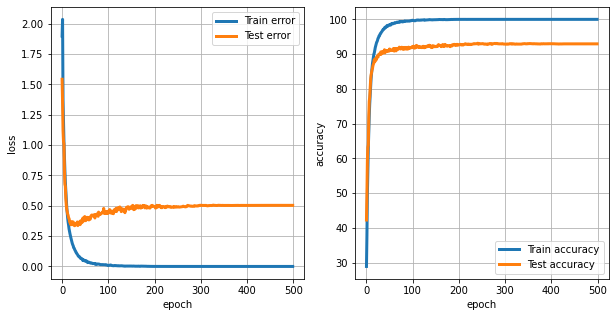

In [11]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(range(num_epochs),train_loss_history,'-',linewidth=3,label='Train error')
plt.plot(range(num_epochs),test_loss_history,'-',linewidth=3,label='Test error')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(num_epochs),train_accuracy_history,'-',linewidth=3,label='Train accuracy')
plt.plot(range(num_epochs),test_accuracy_history,'-',linewidth=3,label='Test accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.grid(True)
plt.legend()

In [12]:
print('Accuracy:',sum(test_accuracy_history[-5:])/5)

Accuracy: 92.94782333374023
